<a href="https://colab.research.google.com/github/wizkers007/fooddetection/blob/main/Food_volume_detection_with_reference_object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter your finger length in cm: 5
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
largest contour area in pixels²: 349874.50
This part is running
Index finger length (pixels): 308.52
Scale factor: 0.01621 cm/px
Largest contour area in cm²: 91.89


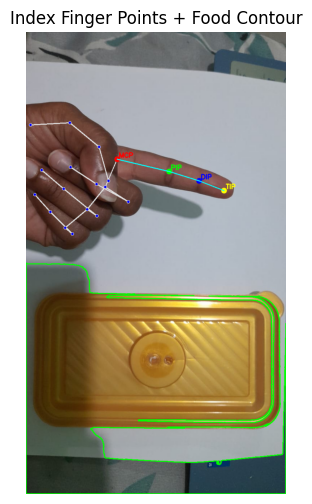

In [19]:
# --- Install dependencies ---
!pip install torch torchvision torchaudio matplotlib
!pip install mediapipe ultralytics

import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import math
from google.colab import files
from google.colab import drive

# --- Step 1: Initialize Mediapipe Hands ---
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# User input for real finger length
try:
    user_input = input("Enter your finger length in cm: ")
    finlength = float(user_input)
except:
    finlength = 7.0  # default if input fails
    print("Invalid input. Using default finger length = 7.0 cm")

hands = mp_hands.Hands(
    static_image_mode=True,   # using uploaded images
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
)

# --- Step 2: Upload image ---
#uploaded = files.upload()
#img_path = list(uploaded.keys())[0]
#img = cv2.imread(img_path)

drive.mount('/content/drive')
img = cv2.imread('/content/drive/MyDrive/l1f.jpg')


# Convert to RGB (for Mediapipe + plotting)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- Step 3: Find contours (for food area) ---
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#edges = cv2.Canny(blurred, 50, 150)
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


pixel_area = None
if len(contours) < 2:
    print("Not enough contours found!")
else:
    contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
    #second_largest_contour = contours_sorted[1]
    largest_contour = contours_sorted[0]

    # Draw contour on image
    cv2.drawContours(img_rgb, [largest_contour], -1, (0, 255, 0), 2)

    # Calculate area
    pixel_area = cv2.contourArea(largest_contour)
    print(f"largest contour area in pixels²: {pixel_area:.2f}")

# --- Step 4: Detect hand + index finger
results = hands.process(img_rgb)
print("This part is running")

if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        # Draw full hand skeleton
        mp_drawing.draw_landmarks(img_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        h, w, c = img_rgb.shape

        # Extract index finger landmarks
        index_points = {
            "MCP": hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP],
            "PIP": hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP],
            "DIP": hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP],
            "TIP": hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP]
        }

        # Colors for each point
        colors = {"MCP": (255, 0, 0), "PIP": (0, 255, 0), "DIP": (0, 0, 255), "TIP": (255, 255, 0)}
        pixel_coords = {}

        # Draw each point
        for name, landmark in index_points.items():
            x, y = int(landmark.x * w), int(landmark.y * h)
            pixel_coords[name] = (x, y)
            cv2.circle(img_rgb, (x, y), 8, colors[name], -1)
            cv2.putText(img_rgb, name, (x+5, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, colors[name], 2)

        # Draw lines between joints
        cv2.line(img_rgb, pixel_coords["MCP"], pixel_coords["PIP"], (0,255,255), 2)
        cv2.line(img_rgb, pixel_coords["PIP"], pixel_coords["DIP"], (0,255,255), 2)
        cv2.line(img_rgb, pixel_coords["DIP"], pixel_coords["TIP"], (0,255,255), 2)

        # Calculate finger length (MCP → TIP)
        tip_x, tip_y = pixel_coords["TIP"]
        base_x, base_y = pixel_coords["MCP"]
        pixel_distance = math.sqrt((tip_x - base_x)**2 + (tip_y - base_y)**2)

        scale = finlength / pixel_distance
        print(f"Index finger length (pixels): {pixel_distance:.2f}")
        print(f"Scale factor: {scale:.5f} cm/px")

        # --- Step 5: Convert food area into cm² ---
        if pixel_area:
            real_area_cm2 = pixel_area * (scale ** 2)
            print(f"Largest contour area in cm²: {real_area_cm2:.2f}")

# --- Step 6: Display result ---
plt.figure(figsize=(8,6))
plt.imshow(img_rgb)
#plt.imshow(thresh)
plt.axis('off')
plt.title("Index Finger Points + Food Contour")
plt.show()